### テーマ：求人
-   今回はtypeというサイトからスクレイピングでデータを取得した
-   取得したデータはDB('salary_data.db')に保存

In [3]:
# グラフ作成のためのライブラリ
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

In [4]:
# スクレイピングに必要なライブラリ
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
# その他(中央値計算など)
import statistics
import re
from datetime import datetime
from scipy import stats # スピアマンの順位相関係数を計算

### 職種別 年収比較

-   各職種の特徴を掴むために、まず職種ごとの平均年収を可視化した
-   各企業が提示している年収範囲の中央値を上位20社分収集し、職種ごとの平均を計算
-   わかりやすく比較するために、平均を表す棒グラフとばらつきを表す箱ひげ図を表示する
-   分析結果は2つのグラフで可視化した  
    -   棒グラフ：職種別の平均年収を比較
    -   箱ひげ図：各職種内でのばらつきを表示

In [16]:
# スクレイピング用クラス(type.jp)
class SalaryAnalyzer:
    
    # DBのセットアップ(初期化)
    # すでにDBが存在するときはDBに接続
    def __init__(self, db_name='salary_data.db'):
        self.db_name = db_name

        # 各職種のURLリスト
        self.job_types = {
            '開発エンジニア': 'https://type.jp/rank/development/',
            'PM/PL/ITコンサル': 'https://type.jp/rank/pm/',
            'インフラ系エンジニア': 'https://type.jp/rank/infrastructure/',
            'その他エンジニア': 'https://type.jp/rank/engineer/',
            '営業': 'https://type.jp/rank/sales/',
            '販売・サービス': 'https://type.jp/rank/service/',
            '事務': 'https://type.jp/rank/office/'
        }
        self.setup_db()

    # DBとテーブルを作成する関数
    def setup_db(self):
        # DBに接続
        con = sqlite3.connect(self.db_name)
        cur = con.cursor()

        # テーブルの作成
        sql = '''CREATE TABLE IF NOT EXISTS salaries (
                id INTEGER PRIMARY KEY AUTOINCREMENT,   -- ID(自動的に割り当てられる)
                job_type TEXT,      -- 職種
                company_rank TEXT,  -- 企業の順位(ランキング)
                salary_text TEXT,   -- 年収(〇〇万円~□□万円)
                salary_median REAL, -- 年収の中央値 
                created_at TIMESTAMP    -- データ取得日時
            )'''

        cur.execute(sql)  # SQLを実行
        con.commit()      # コミット処理(操作をDBに反映)
        con.close()

    # 結果を格納する辞書
    results = {}

    # 中央値を計算する関数
    # インスタンス変数を使わず関数を直接呼び出すためにstaticmethodを使用
    @staticmethod
    def extract_salary_range(salary_text):
        # 給与テキストから数値を抽出し、中央値を計算
        # 正規表現で数値だけを抽出（例：250～1400万円 → [250, 1400]）
        numbers = re.findall(r'\d+', salary_text)   #  ~ の前後の数値を抽出
        if len(numbers) >= 2:
            numbers = [int(num) for num in numbers] # 数値を整数に変換してリストに保存
            return sum(numbers) / 2  # 範囲の中央値を計算
        return None # 数値が2つ未満の場合はNoneを返す

    # スクレイピング関数
    def scrape(self):
        for job_name, url in self.job_types.items():  # .items()でキーと値をペアで取得
                                                      # キー：職種名、値：URL
            try:
                # サイトに負荷をかけないよう待機
                time.sleep(1)
                
                response = requests.get(url)
                response.raise_for_status() # エラーチェック
                soup = BeautifulSoup(response.text, 'html.parser')
                salary_element = soup.select('span.salary')    # 年収のカラム(列)を取得

                # DBに接続
                con = sqlite3.connect(self.db_name)
                cur = con.cursor()

                # 上位20社分のデータを取得
                for rank, element in enumerate(salary_element[:20], 1):  # enumerate()でインデックスと要素を同時に取得
                                                                         # リストの上位20社分のデータを取得
                                                                         # 1からカウントする
                    if element: # 要素が存在する場合
                        salary_text = element.text.strip()  # 年収のテキストを抽出
                        salary_median = self.extract_salary_range(salary_text)  # 中央値を計算
                        if salary_median:
                            # データを挿入するSQL
                            sql_insert = '''INSERT INTO salaries (
                                job_type, 
                                company_rank, 
                                salary_text, 
                                salary_median, 
                                created_at) VALUES (?, ?, ?, ?, ?)'''
                            
                            # datetime()でtimestampを取得
                            # execute()で1レコード(1行)ずつ挿入
                            cur.execute(sql_insert, (job_name, rank, salary_text, salary_median, datetime.now()))

                con.commit()
                con.close()

            except Exception as e:
                print(f"エラーが発生しました: {e}")

    # 各企業の年収の中央値を平均化して可視化する関数
    def analyze(self, job_type=None):   # job_typeを指定しない場合はNone=全職種の分析
        # DBに接続
        con = sqlite3.connect(self.db_name)
        cur = con.cursor()

        # データを取得するSQL
        if job_type:
            # job_typeを指定した場合
            sql_select = '''SELECT job_type, AVG(salary_median) 
                            FROM salaries 
                            WHERE job_type = ? 
                            GROUP BY job_type'''
            cur.execute(sql_select, (job_type,))
        else:
            # job_typeを指定しない場合
            sql_not_select = '''SELECT job_type, AVG(salary_median) 
                            FROM salaries 
                            GROUP BY job_type'''
            cur.execute(sql_not_select)

        results = cur.fetchall()    # 全ての結果をリストで取得
        con.close()

        print("\n=== 職種別 年収中央値 ===")
        for job_type, avg_salary in results:
            print(f"{job_type} : {avg_salary:.1f}万円") # .1f : 小数点以下1桁まで表示

        # グラフを作成
        df = pd.DataFrame(results, columns=['job_type', 'avg_salary'])

        df = df.sort_values('avg_salary', ascending=False)  # 年収の中央値を降順で並べる

        plt.figure(figsize=(10, 5))
        plt.bar(df['job_type'], df['avg_salary'], width=0.6)
        plt.title('職種別 年収平均値')
        plt.xlabel('職種')
        plt.ylabel('年収平均値(万円)')
        plt.tight_layout()  # レイアウトの調整
        plt.show()

    # 職種間で年収の違いを比較する関数
    def compare(self):
        # DBに接続
        con = sqlite3.connect(self.db_name)
        cur = con.cursor()

        # データを取得するSQL
        sql_get = '''SELECT job_type, salary_median, company_rank 
                    FROM salaries'''
        
        # データフレームに変換(今回はSQLをそのままdfに変換)
        df3 = pd.read_sql(sql_get, con)

        # 箱ひげ図を作成
        plt.figure(figsize=(10, 6))

        grouped_data = []   # 年収
        labels = []         # 職種
        
        # 職種ごとグループ化して、年収と職種をそれぞれリストに追加
        for name, group in df3.groupby('job_type'):
            grouped_data.append(group['salary_median'].values)  # .valuesでnumpyに変換
            labels.append(name)

        plt.boxplot(grouped_data, 
                    tick_labels=labels,  # ラベルを職種名に設定
                    vert=False,     # 横向きに設定
                    notch=False)    # ノッチ(くびれ)を消去

        plt.title('職種別の年収分布')
        plt.xlabel('年収(万円)')
        plt.ylabel('職種')
        plt.grid(True, axis='x', alpha=0.3)  # x軸にグリッド線を追加
        plt.tight_layout()  # レイアウトの自動調整
        plt.show()


=== 職種別 年収中央値 ===
PM/PL/ITコンサル : 813.0万円
その他エンジニア : 579.0万円
インフラ系エンジニア : 649.9万円
事務 : 541.6万円
営業 : 616.2万円
販売・サービス : 440.4万円
開発エンジニア : 671.5万円


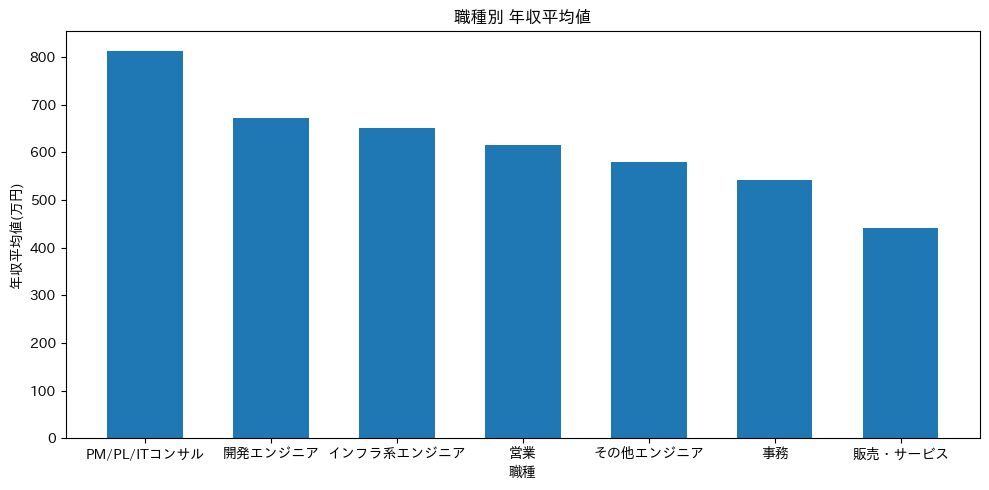

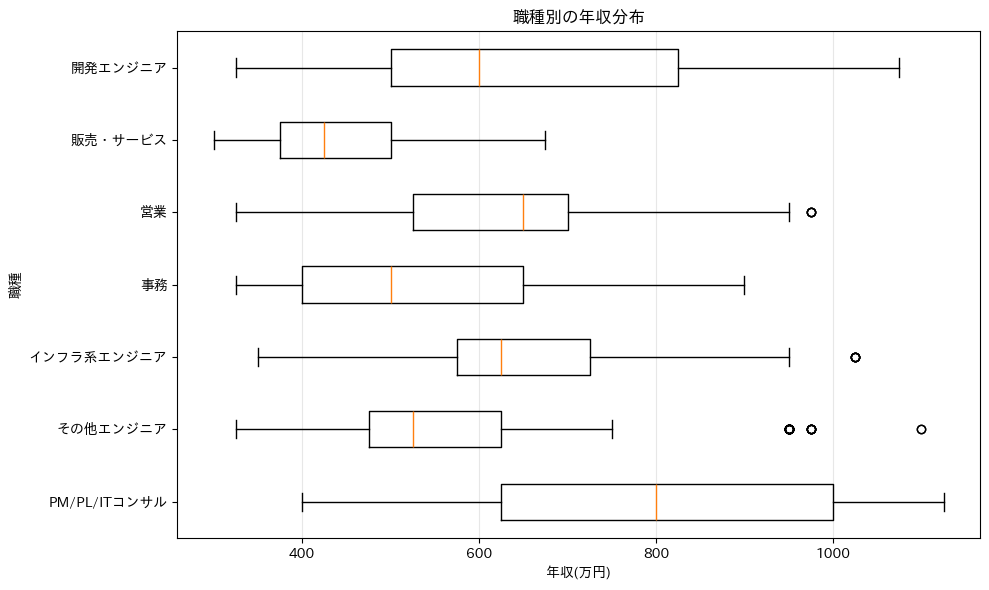

In [17]:
analyzer = SalaryAnalyzer()

analyzer.scrape()
analyzer.analyze()
analyzer.compare()

### 企業順位と年収の関係分析

-   次に企業の順位と年収には関係があるのかを調べた
-   2者間の相関係数を2つの方法(ピアソン相関係数, スピアマンの順位相関係数)で計算した
-   結果を散布図と聞き直線で可視化した

In [21]:
class MoreAnalyze:
    # DBに接続
    def __init__(self, db_name='salary_data.db'):
        self.db_name = db_name

    # 企業の順位と年収の関係を分析する関数
    def analyze_rank(self, job_type=None):
        # DBに接続
        con = sqlite3.connect(self.db_name)
        cur = con.cursor()

        if job_type:
            # job_typeを指定した場合
            sql_select2 = '''SELECT company_rank, salary_median 
                            FROM salaries 
                            WHERE job_type = ?'''
            cur.execute(sql_select2, (job_type,))

        else:
            # job_typeを指定しない場合
            sql_not_select2 = '''SELECT company_rank, salary_median 
                            FROM salaries'''
            cur.execute(sql_not_select2)

        results = cur.fetchall()    # 全ての結果をリストで取得
        con.close()

        # データフレームに変換
        df2 = pd.DataFrame(results, columns=['company_rank', 'salary_median'])
        df2['company_rank'] = df2['company_rank'].astype(int)   # company_rankをint型(数値)に変換

        # ピアソン相関係数を計算(直線的な関係を見る)
        corr = df2['company_rank'].corr(df2['salary_median'])
        print(f'ピアソン相関係数: {corr:.2f}')

        # スピアマンの順位相関係数を計算(順位に基づく相関を見る)
        correlation, p_value = stats.spearmanr(df2['company_rank'], df2['salary_median'])
        print(f'スピアマン相関係数: {correlation:.3f}')
        print(f'p値: {p_value:.5f}')
        if p_value < 0.05:
            print('統計的に有意な相関がある')
        else:
            print('統計的に有意な相関がない')

        # 散布図を作成
        plt.figure(figsize=(10, 6))
        plt.scatter(x=df2['company_rank'], y=df2['salary_median'])

        # 回帰直線を追加
        x = np.polyfit(df2['company_rank'], df2['salary_median'], 1)    # x, y, 次数(=1次式)を指定
                                                                        # y=ax+bのa,b(係数)を計算
        y = np.poly1d(x)    # すなわち f(x)=ax+b
        plt.plot(df2['company_rank'], y(df2['company_rank']), color='red')  # 赤色の実線で線画("r--"だと赤破線)

        # x軸の目盛りを2ずつに設定
        plt.xticks(range(0, 22, 2))  # 0~22まで2刻みで目盛りを設定

        plt.title('企業の順位と年収の関係')
        if job_type:  # job_typeが指定されている(Noneではない)場合
            title += f' ({job_type})'
            plt.title(title)
        plt.xlabel('企業の順位')
        plt.ylabel('年収中央値(万円)')

ピアソン相関係数: -0.11
スピアマン相関係数: -0.110
p値: 0.00001
統計的に有意な相関がある


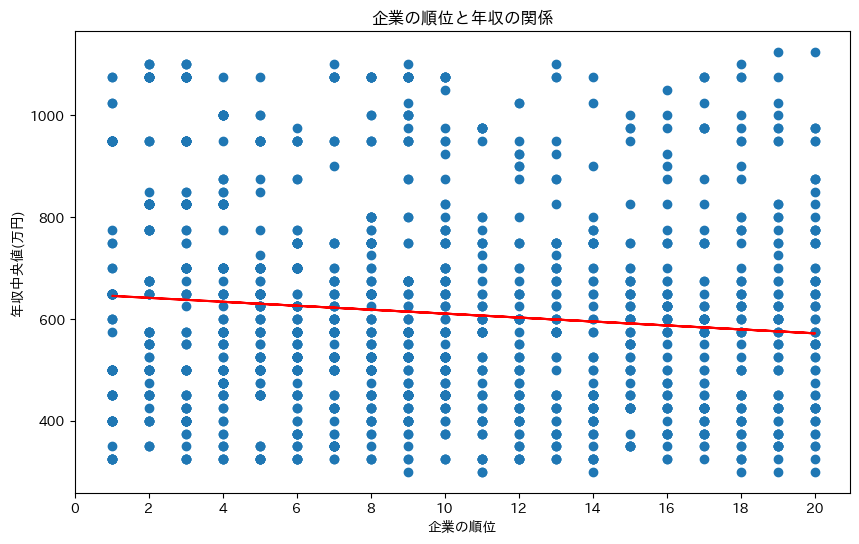

In [22]:
more_analyze = MoreAnalyze()

more_analyze.analyze_rank()